## NN datos balanceados oversampling



(4781, 9000)


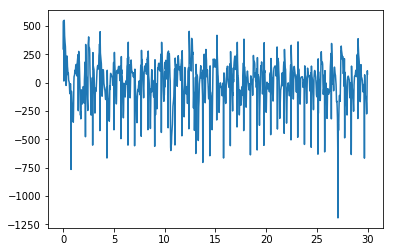

In [1]:
#load data
#load data
%matplotlib inline
import matplotlib.pyplot as plt
#load data
import numpy as np

X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')

X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

#Decimamos

X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')

X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

fs = 300. #Hz
t = np.arange(len(X_train[0]))/fs
plt.plot(t,X_train[0,:])

#Es probable que tengamos un problema mal condicionado: vamos a realizar un submuestreo de la señal a 50 muestras por segundo
from scipy import signal

decimate = False

if decimate:
    freq = fs/10#Hz
    print(freq)
    secs = len(X_train[200])/fs
    samps = int(secs*freq)
    c = 0
    X_new = np.zeros((X_train.shape[0],samps))
    X_new_test = np.zeros((X_test.shape[0],samps))
    for x,x_test in zip(X_train,X_test):
        X_new[c,:] = signal.decimate(x,10,ftype = 'fir')
        X_new_test[c,:] = signal.decimate(x_test,10,ftype = 'fir')
    
        c += 1
    
    t = np.arange(len(X_new[200]))/freq
    plt.plot(t,X_new[200,:])
    print(len(X_new[0]))

    X_train = X_new.copy()
    X_test = X_new_test.copy()
    
print(X_train.shape)

In [2]:
from sklearn.preprocessing import StandardScaler

#normalizamos train
my_scaler = StandardScaler()

X_train_n = my_scaler.fit_transform(X_train)

/home/obarquero/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [3]:
#Vamos a probar balanceando con under sampling y over sampling
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0, replacement=True)
X_resampled, y_resampled = rus.fit_sample(X_train_n, y_train)

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_oversampled, y_oversampled = ros.fit_sample(X_train_n, y_train)

print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print("y_resampled")
print(sorted(Counter(y_resampled).items()))

print("y_oversampled")
print(sorted(Counter(y_oversampled).items()))


print("y_train")
print(sorted(Counter(y_train).items()))

"""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""
y_resampled
[(0, 100), (1, 100), (2, 100), (3, 100)]
y_oversampled
[(0, 2942), (1, 2942), (2, 2942), (3, 2942)]
y_train
[(0, 2942), (1, 399), (2, 1340), (3, 100)]


In [4]:
#función para crear un modelo de un número determinado de capas

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras import initializers
from keras.layers.normalization import BatchNormalization
import keras


#f1 score
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def create_model(N,n_hidd = [2,2,2],p = 0):
    """
    Modelo de red neuronal. 
    
    N: number of input featurs
    n_hidd indica la arquitectura del modelo: n_cols = número de capas, value for eahc col, the number of hidden
    units
    """
    
    model = Sequential()
    
    #input layer
    model.add(Dense(n_hidd[0],input_dim = N,activation = 'relu'))
    model.add(BatchNormalization())
    
    #hidden layers
    for n_h in n_hidd[1:]:
        model.add(Dense(n_h,activation='relu',kernel_initializer=initializers.he_normal(seed=None)))
        model.add(BatchNormalization())  
        model.add(Dropout(p))
        
    #output layer
    model.add(Dense(4,activation = 'softmax'))
   

    opt =keras.optimizers.Adam(lr = 4e-2)
    #compile model
    model.compile(loss='categorical_crossentropy',optimizer = opt,metrics = ['accuracy',f1])
    return model

/home/obarquero/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
## dev and train split

#Split data into dev and trin
from sklearn.model_selection import StratifiedShuffleSplit
skf = StratifiedShuffleSplit(n_splits = 1,test_size = 0.20)

#WARNING que volvemos a llamar train
for train, dev in skf.split(X_oversampled,y_oversampled):
    X_train, X_dev = X_oversampled[train], X_oversampled[dev]
    y_train, y_dev = y_oversampled[train], y_oversampled[dev]
    
print(X_train.shape)
print(X_dev.shape)

(9414, 9000)
(2354, 9000)


In [6]:
#Entrenamos el modelo 

N = X_train.shape[1]#number of features
#n_h = [int(N/2),int(N/4),int(N/8),int(N/16),int(N/32)]
n_h = [6,3,3]
print(n_h)
print(N)
prob_dropout = 0.6
model = KerasClassifier(build_fn = create_model,N=N,n_hidd=n_h, p = prob_dropout,epochs = 1500, batch_size = 100, verbose = 1)

history = model.fit(X_train,y_train)

[6, 3, 3]
9000
Epoch 1/1500
9414/9414 [==============================] - 4s 379us/step - loss: 1.3856 - acc: 0.2754 - f1: 0.0380
Epoch 2/1500
9414/9414 [==============================] - 3s 292us/step - loss: 1.3590 - acc: 0.2818 - f1: 0.0570
Epoch 3/1500
9414/9414 [==============================] - 3s 331us/step - loss: 1.3049 - acc: 0.3143 - f1: 0.1243
Epoch 4/1500
9414/9414 [==============================] - 3s 316us/step - loss: 1.2680 - acc: 0.3480 - f1: 0.16410s - loss: 1.2701 - acc: 0.347
Epoch 5/1500
9414/9414 [==============================] - 3s 303us/step - loss: 1.2448 - acc: 0.3530 - f1: 0.1763
Epoch 6/1500
9414/9414 [==============================] - 3s 336us/step - loss: 1.2381 - acc: 0.3603 - f1: 0.1818
Epoch 7/1500
9414/9414 [==============================] - 3s 326us/step - loss: 1.2201 - acc: 0.3657 - f1: 0.1978
Epoch 8/1500
9414/9414 [==============================] - 3s 301us/step - loss: 1.2209 - acc: 0.3685 - f1: 0.18750s - loss: 1.2262 - ac
Epoch 9/1500
9414/941

9414/9414 [==============================] - 2s 234us/step - loss: 1.1492 - acc: 0.3788 - f1: 0.2313
Epoch 72/1500
9414/9414 [==============================] - 3s 270us/step - loss: 1.1534 - acc: 0.3775 - f1: 0.2319
Epoch 73/1500
9414/9414 [==============================] - 2s 224us/step - loss: 1.1556 - acc: 0.3828 - f1: 0.2289
Epoch 74/1500
9414/9414 [==============================] - 2s 228us/step - loss: 1.1470 - acc: 0.3794 - f1: 0.2339
Epoch 75/1500
9414/9414 [==============================] - 2s 254us/step - loss: 1.1478 - acc: 0.3733 - f1: 0.2289
Epoch 76/1500
9414/9414 [==============================] - 2s 210us/step - loss: 1.1465 - acc: 0.3859 - f1: 0.2317
Epoch 77/1500
9414/9414 [==============================] - 2s 248us/step - loss: 1.1537 - acc: 0.3817 - f1: 0.2298
Epoch 78/1500
9414/9414 [==============================] - 3s 278us/step - loss: 1.1617 - acc: 0.3849 - f1: 0.2290
Epoch 79/1500
9414/9414 [==============================] - 2s 263us/step - loss: 1.1568 - acc:

9414/9414 [==============================] - 2s 241us/step - loss: 1.1424 - acc: 0.3873 - f1: 0.2374
Epoch 142/1500
9414/9414 [==============================] - 2s 220us/step - loss: 1.1885 - acc: 0.3701 - f1: 0.2125
Epoch 143/1500
9414/9414 [==============================] - 2s 233us/step - loss: 1.1737 - acc: 0.3706 - f1: 0.2199
Epoch 144/1500
9414/9414 [==============================] - 3s 277us/step - loss: 1.1508 - acc: 0.3820 - f1: 0.2362
Epoch 145/1500
9414/9414 [==============================] - 2s 253us/step - loss: 1.1511 - acc: 0.3777 - f1: 0.2212
Epoch 146/1500
9414/9414 [==============================] - 2s 241us/step - loss: 1.1430 - acc: 0.3784 - f1: 0.2348
Epoch 147/1500
9414/9414 [==============================] - 3s 279us/step - loss: 1.1484 - acc: 0.3804 - f1: 0.2299
Epoch 148/1500
9414/9414 [==============================] - 2s 241us/step - loss: 1.1413 - acc: 0.3850 - f1: 0.2334
Epoch 149/1500
9414/9414 [==============================] - 2s 250us/step - loss: 1.153

9414/9414 [==============================] - 2s 214us/step - loss: 1.1479 - acc: 0.3826 - f1: 0.2319
Epoch 212/1500
9414/9414 [==============================] - 2s 230us/step - loss: 1.1455 - acc: 0.3806 - f1: 0.2302
Epoch 213/1500
9414/9414 [==============================] - 2s 234us/step - loss: 1.1523 - acc: 0.3857 - f1: 0.2311
Epoch 214/1500
9414/9414 [==============================] - 2s 231us/step - loss: 1.1556 - acc: 0.3662 - f1: 0.2227
Epoch 215/1500
9414/9414 [==============================] - 2s 223us/step - loss: 1.1514 - acc: 0.3828 - f1: 0.2271
Epoch 216/1500
9414/9414 [==============================] - 2s 227us/step - loss: 1.1514 - acc: 0.3800 - f1: 0.2319
Epoch 217/1500
9414/9414 [==============================] - 2s 259us/step - loss: 1.1554 - acc: 0.3764 - f1: 0.2298
Epoch 218/1500
9414/9414 [==============================] - 2s 228us/step - loss: 1.1517 - acc: 0.3829 - f1: 0.2309
Epoch 219/1500
9414/9414 [==============================] - 2s 217us/step - loss: 1.152

9414/9414 [==============================] - 2s 218us/step - loss: 1.1402 - acc: 0.3927 - f1: 0.2325
Epoch 282/1500
9414/9414 [==============================] - 2s 227us/step - loss: 1.1438 - acc: 0.3860 - f1: 0.2303
Epoch 283/1500
9414/9414 [==============================] - 3s 269us/step - loss: 1.1360 - acc: 0.3850 - f1: 0.2375
Epoch 284/1500
9414/9414 [==============================] - 2s 248us/step - loss: 1.1404 - acc: 0.3895 - f1: 0.2350
Epoch 285/1500
9414/9414 [==============================] - 2s 223us/step - loss: 1.1386 - acc: 0.3877 - f1: 0.2376
Epoch 286/1500
9414/9414 [==============================] - 2s 262us/step - loss: 1.1403 - acc: 0.3888 - f1: 0.2350
Epoch 287/1500
9414/9414 [==============================] - 3s 271us/step - loss: 1.1487 - acc: 0.3872 - f1: 0.2287
Epoch 288/1500
9414/9414 [==============================] - 2s 227us/step - loss: 1.1502 - acc: 0.3926 - f1: 0.2309
Epoch 289/1500
9414/9414 [==============================] - 2s 236us/step - loss: 1.139

9414/9414 [==============================] - 2s 243us/step - loss: 1.1423 - acc: 0.3818 - f1: 0.2333
Epoch 352/1500
9414/9414 [==============================] - 2s 222us/step - loss: 1.1415 - acc: 0.3825 - f1: 0.2364
Epoch 353/1500
9414/9414 [==============================] - 2s 256us/step - loss: 1.1344 - acc: 0.3988 - f1: 0.2473
Epoch 354/1500
9414/9414 [==============================] - 2s 223us/step - loss: 1.1696 - acc: 0.3802 - f1: 0.2232
Epoch 355/1500
9414/9414 [==============================] - 2s 242us/step - loss: 1.1586 - acc: 0.3785 - f1: 0.2236
Epoch 356/1500
9414/9414 [==============================] - 2s 239us/step - loss: 1.1462 - acc: 0.3873 - f1: 0.2298
Epoch 357/1500
9414/9414 [==============================] - 2s 235us/step - loss: 1.1367 - acc: 0.3870 - f1: 0.2376
Epoch 358/1500
9414/9414 [==============================] - 2s 223us/step - loss: 1.1405 - acc: 0.3840 - f1: 0.2329
Epoch 359/1500
9414/9414 [==============================] - 2s 232us/step - loss: 1.154

9414/9414 [==============================] - 2s 227us/step - loss: 1.1564 - acc: 0.3748 - f1: 0.2259
Epoch 422/1500
9414/9414 [==============================] - 2s 221us/step - loss: 1.1639 - acc: 0.3741 - f1: 0.2205
Epoch 423/1500
9414/9414 [==============================] - 2s 258us/step - loss: 1.1563 - acc: 0.3843 - f1: 0.2299
Epoch 424/1500
9414/9414 [==============================] - 2s 209us/step - loss: 1.1585 - acc: 0.3798 - f1: 0.2235
Epoch 425/1500
9414/9414 [==============================] - 2s 242us/step - loss: 1.1539 - acc: 0.3785 - f1: 0.2248
Epoch 426/1500
9414/9414 [==============================] - 2s 236us/step - loss: 1.1480 - acc: 0.3802 - f1: 0.2323
Epoch 427/1500
9414/9414 [==============================] - 2s 254us/step - loss: 1.1505 - acc: 0.3813 - f1: 0.2312
Epoch 428/1500
9414/9414 [==============================] - 2s 230us/step - loss: 1.1544 - acc: 0.3772 - f1: 0.2274
Epoch 429/1500
9414/9414 [==============================] - 2s 247us/step - loss: 1.150

9414/9414 [==============================] - 2s 235us/step - loss: 1.1542 - acc: 0.3789 - f1: 0.2272
Epoch 492/1500
9414/9414 [==============================] - 2s 226us/step - loss: 1.1525 - acc: 0.3809 - f1: 0.2274
Epoch 493/1500
9414/9414 [==============================] - 2s 200us/step - loss: 1.1538 - acc: 0.3815 - f1: 0.2256
Epoch 494/1500
9414/9414 [==============================] - 3s 272us/step - loss: 1.1520 - acc: 0.3810 - f1: 0.2279
Epoch 495/1500
9414/9414 [==============================] - 2s 225us/step - loss: 1.1511 - acc: 0.3825 - f1: 0.2263
Epoch 496/1500
9414/9414 [==============================] - 2s 242us/step - loss: 1.1554 - acc: 0.3842 - f1: 0.2291
Epoch 497/1500
9414/9414 [==============================] - 2s 229us/step - loss: 1.1544 - acc: 0.3752 - f1: 0.2236
Epoch 498/1500
9414/9414 [==============================] - 2s 230us/step - loss: 1.1551 - acc: 0.3787 - f1: 0.2260
Epoch 499/1500
9414/9414 [==============================] - 2s 230us/step - loss: 1.150

9414/9414 [==============================] - 2s 251us/step - loss: 1.1621 - acc: 0.3813 - f1: 0.2302
Epoch 562/1500
9414/9414 [==============================] - 2s 237us/step - loss: 1.1528 - acc: 0.3828 - f1: 0.2326
Epoch 563/1500
9414/9414 [==============================] - 2s 232us/step - loss: 1.1527 - acc: 0.3828 - f1: 0.2333
Epoch 564/1500
9414/9414 [==============================] - 2s 232us/step - loss: 1.1519 - acc: 0.3819 - f1: 0.2307
Epoch 565/1500
9414/9414 [==============================] - 2s 236us/step - loss: 1.1447 - acc: 0.3915 - f1: 0.2326
Epoch 566/1500
9414/9414 [==============================] - 2s 213us/step - loss: 1.1516 - acc: 0.3821 - f1: 0.2289
Epoch 567/1500
9414/9414 [==============================] - 2s 258us/step - loss: 1.1429 - acc: 0.3839 - f1: 0.2347
Epoch 568/1500
9414/9414 [==============================] - 2s 264us/step - loss: 1.1461 - acc: 0.3880 - f1: 0.2342
Epoch 569/1500
9414/9414 [==============================] - 2s 228us/step - loss: 1.141

9414/9414 [==============================] - 2s 233us/step - loss: 1.1428 - acc: 0.3909 - f1: 0.2344
Epoch 632/1500
9414/9414 [==============================] - 2s 218us/step - loss: 1.1410 - acc: 0.3795 - f1: 0.2340
Epoch 633/1500
9414/9414 [==============================] - 2s 209us/step - loss: 1.1428 - acc: 0.3887 - f1: 0.2315
Epoch 634/1500
9414/9414 [==============================] - 2s 233us/step - loss: 1.1474 - acc: 0.3792 - f1: 0.2275
Epoch 635/1500
9414/9414 [==============================] - 2s 252us/step - loss: 1.1503 - acc: 0.3842 - f1: 0.2329
Epoch 636/1500
9414/9414 [==============================] - 2s 237us/step - loss: 1.1477 - acc: 0.3812 - f1: 0.2287
Epoch 637/1500
9414/9414 [==============================] - 2s 230us/step - loss: 1.1452 - acc: 0.3812 - f1: 0.2320
Epoch 638/1500
9414/9414 [==============================] - 3s 267us/step - loss: 1.1409 - acc: 0.3743 - f1: 0.2341
Epoch 639/1500
9414/9414 [==============================] - 2s 232us/step - loss: 1.142

9414/9414 [==============================] - 2s 245us/step - loss: 1.1407 - acc: 0.3833 - f1: 0.2367
Epoch 702/1500
9414/9414 [==============================] - 2s 250us/step - loss: 1.1478 - acc: 0.3807 - f1: 0.2333
Epoch 703/1500
9414/9414 [==============================] - 2s 236us/step - loss: 1.1516 - acc: 0.3768 - f1: 0.2266
Epoch 704/1500
9414/9414 [==============================] - 2s 240us/step - loss: 1.1552 - acc: 0.3694 - f1: 0.2248
Epoch 705/1500
9414/9414 [==============================] - 2s 214us/step - loss: 1.1410 - acc: 0.3855 - f1: 0.2353
Epoch 706/1500
9414/9414 [==============================] - 2s 224us/step - loss: 1.1449 - acc: 0.3896 - f1: 0.2341
Epoch 707/1500
9414/9414 [==============================] - 2s 237us/step - loss: 1.1393 - acc: 0.3887 - f1: 0.2376
Epoch 708/1500
9414/9414 [==============================] - 2s 254us/step - loss: 1.1435 - acc: 0.3869 - f1: 0.2304
Epoch 709/1500
9414/9414 [==============================] - 2s 245us/step - loss: 1.145

9414/9414 [==============================] - 3s 281us/step - loss: 1.1477 - acc: 0.3804 - f1: 0.2286
Epoch 772/1500
9414/9414 [==============================] - 2s 243us/step - loss: 1.1490 - acc: 0.3808 - f1: 0.2321
Epoch 773/1500
9414/9414 [==============================] - 2s 227us/step - loss: 1.1491 - acc: 0.3878 - f1: 0.2316
Epoch 774/1500
9414/9414 [==============================] - 2s 253us/step - loss: 1.1494 - acc: 0.3806 - f1: 0.23260s - loss: 1.1473 - acc: 0.3809 - f1: 
Epoch 775/1500
9414/9414 [==============================] - 2s 231us/step - loss: 1.1554 - acc: 0.3891 - f1: 0.2311
Epoch 776/1500
9414/9414 [==============================] - 2s 242us/step - loss: 1.1487 - acc: 0.3728 - f1: 0.2292
Epoch 777/1500
9414/9414 [==============================] - 2s 243us/step - loss: 1.1518 - acc: 0.3751 - f1: 0.2288
Epoch 778/1500
9414/9414 [==============================] - 2s 263us/step - loss: 1.1512 - acc: 0.3765 - f1: 0.2314
Epoch 779/1500
9414/9414 [=======================

9414/9414 [==============================] - 2s 260us/step - loss: 1.1504 - acc: 0.3895 - f1: 0.2294
Epoch 842/1500
9414/9414 [==============================] - 2s 233us/step - loss: 1.1516 - acc: 0.3907 - f1: 0.2289
Epoch 843/1500
9414/9414 [==============================] - 2s 250us/step - loss: 1.1439 - acc: 0.3825 - f1: 0.2332
Epoch 844/1500
9414/9414 [==============================] - 2s 227us/step - loss: 1.1531 - acc: 0.3833 - f1: 0.2241
Epoch 845/1500
9414/9414 [==============================] - 2s 235us/step - loss: 1.1394 - acc: 0.3872 - f1: 0.2373
Epoch 846/1500
9414/9414 [==============================] - 2s 224us/step - loss: 1.1527 - acc: 0.3842 - f1: 0.2278
Epoch 847/1500
9414/9414 [==============================] - 2s 235us/step - loss: 1.1513 - acc: 0.3753 - f1: 0.2281
Epoch 848/1500
9414/9414 [==============================] - 2s 260us/step - loss: 1.1423 - acc: 0.3909 - f1: 0.2315
Epoch 849/1500
9414/9414 [==============================] - 2s 213us/step - loss: 1.145

9414/9414 [==============================] - 2s 209us/step - loss: 1.1357 - acc: 0.3892 - f1: 0.2372
Epoch 912/1500
9414/9414 [==============================] - 2s 264us/step - loss: 1.1517 - acc: 0.3853 - f1: 0.2276
Epoch 913/1500
9414/9414 [==============================] - 2s 220us/step - loss: 1.1465 - acc: 0.3830 - f1: 0.2302
Epoch 914/1500
9414/9414 [==============================] - 2s 234us/step - loss: 1.1444 - acc: 0.3828 - f1: 0.2334
Epoch 915/1500
9414/9414 [==============================] - 2s 237us/step - loss: 1.1468 - acc: 0.3828 - f1: 0.2332
Epoch 916/1500
9414/9414 [==============================] - 2s 217us/step - loss: 1.1352 - acc: 0.3859 - f1: 0.2405
Epoch 917/1500
9414/9414 [==============================] - 2s 225us/step - loss: 1.1427 - acc: 0.3801 - f1: 0.2324
Epoch 918/1500
9414/9414 [==============================] - 2s 238us/step - loss: 1.1515 - acc: 0.3827 - f1: 0.2297
Epoch 919/1500
9414/9414 [==============================] - ETA: 0s - loss: 1.1464 - ac

9414/9414 [==============================] - 2s 238us/step - loss: 1.1478 - acc: 0.3806 - f1: 0.2288
Epoch 982/1500
9414/9414 [==============================] - 2s 260us/step - loss: 1.1405 - acc: 0.3866 - f1: 0.2341
Epoch 983/1500
9414/9414 [==============================] - 2s 230us/step - loss: 1.1382 - acc: 0.3931 - f1: 0.2349
Epoch 984/1500
9414/9414 [==============================] - 2s 223us/step - loss: 1.1406 - acc: 0.3806 - f1: 0.2351
Epoch 985/1500
9414/9414 [==============================] - 2s 249us/step - loss: 1.1439 - acc: 0.3799 - f1: 0.2318
Epoch 986/1500
9414/9414 [==============================] - 2s 233us/step - loss: 1.1413 - acc: 0.3821 - f1: 0.2354
Epoch 987/1500
9414/9414 [==============================] - 2s 218us/step - loss: 1.1451 - acc: 0.3830 - f1: 0.2343
Epoch 988/1500
9414/9414 [==============================] - 2s 232us/step - loss: 1.1421 - acc: 0.3895 - f1: 0.2318
Epoch 989/1500
9414/9414 [==============================] - 2s 253us/step - loss: 1.140

9414/9414 [==============================] - 2s 232us/step - loss: 1.1471 - acc: 0.3901 - f1: 0.2291
Epoch 1051/1500
9414/9414 [==============================] - 2s 217us/step - loss: 1.1403 - acc: 0.3887 - f1: 0.2349
Epoch 1052/1500
9414/9414 [==============================] - 2s 255us/step - loss: 1.1463 - acc: 0.3859 - f1: 0.2308
Epoch 1053/1500
9414/9414 [==============================] - 2s 220us/step - loss: 1.1444 - acc: 0.3778 - f1: 0.2320
Epoch 1054/1500
9414/9414 [==============================] - 2s 252us/step - loss: 1.1413 - acc: 0.3818 - f1: 0.2354
Epoch 1055/1500
9414/9414 [==============================] - 3s 275us/step - loss: 1.1454 - acc: 0.3909 - f1: 0.2381
Epoch 1056/1500
9414/9414 [==============================] - 2s 228us/step - loss: 1.1458 - acc: 0.3821 - f1: 0.2304
Epoch 1057/1500
9414/9414 [==============================] - 2s 228us/step - loss: 1.1440 - acc: 0.3843 - f1: 0.2345
Epoch 1058/1500
9414/9414 [==============================] - 2s 228us/step - los

9414/9414 [==============================] - 2s 253us/step - loss: 1.1306 - acc: 0.3894 - f1: 0.2440
Epoch 1121/1500
9414/9414 [==============================] - 2s 231us/step - loss: 1.1390 - acc: 0.3832 - f1: 0.2368
Epoch 1122/1500
9414/9414 [==============================] - 2s 262us/step - loss: 1.1385 - acc: 0.3883 - f1: 0.2407
Epoch 1123/1500
9414/9414 [==============================] - 2s 218us/step - loss: 1.1335 - acc: 0.3852 - f1: 0.2381
Epoch 1124/1500
9414/9414 [==============================] - 2s 256us/step - loss: 1.1366 - acc: 0.3760 - f1: 0.2341
Epoch 1125/1500
9414/9414 [==============================] - 2s 213us/step - loss: 1.1340 - acc: 0.3818 - f1: 0.2390
Epoch 1126/1500
9414/9414 [==============================] - 2s 253us/step - loss: 1.1467 - acc: 0.3855 - f1: 0.2298
Epoch 1127/1500
9414/9414 [==============================] - 2s 232us/step - loss: 1.1361 - acc: 0.3782 - f1: 0.2375
Epoch 1128/1500
9414/9414 [==============================] - 2s 226us/step - los

9414/9414 [==============================] - 2s 235us/step - loss: 1.1381 - acc: 0.3853 - f1: 0.2347
Epoch 1191/1500
9414/9414 [==============================] - 2s 220us/step - loss: 1.1355 - acc: 0.3825 - f1: 0.2370
Epoch 1192/1500
9414/9414 [==============================] - 2s 214us/step - loss: 1.1340 - acc: 0.3871 - f1: 0.2408
Epoch 1193/1500
9414/9414 [==============================] - 2s 245us/step - loss: 1.1304 - acc: 0.3883 - f1: 0.2393
Epoch 1194/1500
9414/9414 [==============================] - 2s 211us/step - loss: 1.1315 - acc: 0.3911 - f1: 0.23560s - loss: 1.1301 - acc:
Epoch 1195/1500
9414/9414 [==============================] - 2s 237us/step - loss: 1.1305 - acc: 0.3984 - f1: 0.2394
Epoch 1196/1500
9414/9414 [==============================] - 2s 233us/step - loss: 1.1373 - acc: 0.3911 - f1: 0.2347
Epoch 1197/1500
9414/9414 [==============================] - 2s 236us/step - loss: 1.1404 - acc: 0.3798 - f1: 0.2275
Epoch 1198/1500
9414/9414 [=============================

9414/9414 [==============================] - 2s 205us/step - loss: 1.1304 - acc: 0.3907 - f1: 0.2387
Epoch 1260/1500
9414/9414 [==============================] - 2s 220us/step - loss: 1.1307 - acc: 0.3834 - f1: 0.2459
Epoch 1261/1500
9414/9414 [==============================] - 2s 220us/step - loss: 1.1359 - acc: 0.3942 - f1: 0.2364
Epoch 1262/1500
9414/9414 [==============================] - 2s 254us/step - loss: 1.1353 - acc: 0.3946 - f1: 0.2406
Epoch 1263/1500
9414/9414 [==============================] - 2s 227us/step - loss: 1.1325 - acc: 0.3881 - f1: 0.2360
Epoch 1264/1500
9414/9414 [==============================] - 2s 256us/step - loss: 1.1216 - acc: 0.3924 - f1: 0.2424
Epoch 1265/1500
9414/9414 [==============================] - 2s 234us/step - loss: 1.1270 - acc: 0.3975 - f1: 0.2378
Epoch 1266/1500
9414/9414 [==============================] - 2s 264us/step - loss: 1.1339 - acc: 0.3866 - f1: 0.2357
Epoch 1267/1500
9414/9414 [==============================] - 2s 207us/step - los

9414/9414 [==============================] - 3s 267us/step - loss: 1.1338 - acc: 0.3892 - f1: 0.2364
Epoch 1330/1500
9414/9414 [==============================] - 2s 228us/step - loss: 1.1395 - acc: 0.3888 - f1: 0.2338
Epoch 1331/1500
9414/9414 [==============================] - 2s 216us/step - loss: 1.1340 - acc: 0.3881 - f1: 0.2417
Epoch 1332/1500
9414/9414 [==============================] - 2s 246us/step - loss: 1.1380 - acc: 0.3862 - f1: 0.2335
Epoch 1333/1500
9414/9414 [==============================] - 2s 242us/step - loss: 1.1350 - acc: 0.3823 - f1: 0.2367
Epoch 1334/1500
9414/9414 [==============================] - 2s 233us/step - loss: 1.1331 - acc: 0.3856 - f1: 0.2351
Epoch 1335/1500
9414/9414 [==============================] - 2s 228us/step - loss: 1.1330 - acc: 0.3862 - f1: 0.2412
Epoch 1336/1500
9414/9414 [==============================] - 2s 223us/step - loss: 1.1375 - acc: 0.3769 - f1: 0.2312
Epoch 1337/1500
9414/9414 [==============================] - 2s 243us/step - los

9414/9414 [==============================] - 2s 210us/step - loss: 1.1376 - acc: 0.3845 - f1: 0.2330
Epoch 1400/1500
9414/9414 [==============================] - 2s 240us/step - loss: 1.1317 - acc: 0.3900 - f1: 0.2370
Epoch 1401/1500
9414/9414 [==============================] - 2s 230us/step - loss: 1.1388 - acc: 0.3787 - f1: 0.2340
Epoch 1402/1500
9414/9414 [==============================] - 2s 212us/step - loss: 1.1488 - acc: 0.3911 - f1: 0.2303
Epoch 1403/1500
9414/9414 [==============================] - 2s 222us/step - loss: 1.1462 - acc: 0.3837 - f1: 0.2342
Epoch 1404/1500
9414/9414 [==============================] - 2s 245us/step - loss: 1.1343 - acc: 0.3886 - f1: 0.2421
Epoch 1405/1500
9414/9414 [==============================] - 2s 232us/step - loss: 1.1432 - acc: 0.3879 - f1: 0.2307
Epoch 1406/1500
9414/9414 [==============================] - 3s 271us/step - loss: 1.1364 - acc: 0.3813 - f1: 0.2357
Epoch 1407/1500
9414/9414 [==============================] - 2s 259us/step - los

9414/9414 [==============================] - 2s 222us/step - loss: 1.1373 - acc: 0.3812 - f1: 0.2371
Epoch 1470/1500
9414/9414 [==============================] - 2s 261us/step - loss: 1.1448 - acc: 0.3766 - f1: 0.2307
Epoch 1471/1500
9414/9414 [==============================] - 2s 243us/step - loss: 1.1384 - acc: 0.3861 - f1: 0.2374
Epoch 1472/1500
9414/9414 [==============================] - 2s 225us/step - loss: 1.1484 - acc: 0.3817 - f1: 0.2285
Epoch 1473/1500
9414/9414 [==============================] - 2s 220us/step - loss: 1.1476 - acc: 0.3821 - f1: 0.2270
Epoch 1474/1500
9414/9414 [==============================] - 2s 254us/step - loss: 1.1352 - acc: 0.3906 - f1: 0.2364
Epoch 1475/1500
9414/9414 [==============================] - 2s 232us/step - loss: 1.1418 - acc: 0.3806 - f1: 0.2325
Epoch 1476/1500
9414/9414 [==============================] - 2s 223us/step - loss: 1.1386 - acc: 0.3861 - f1: 0.2340
Epoch 1477/1500
9414/9414 [==============================] - 2s 249us/step - los

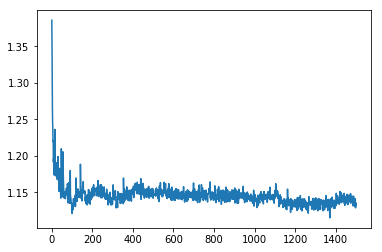

In [7]:
#plot loss
loss = history.history['loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss)


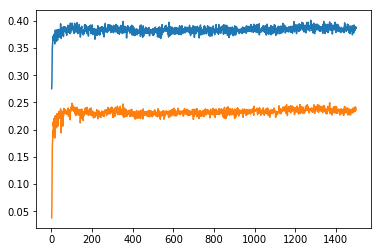

In [8]:
#plot accuracy and f1
acc = history.history['acc']
f1 = history.history['f1']

epochs = range(1,len(loss)+1)

plt.plot(epochs,acc)
plt.plot(epochs,f1)


In [9]:
from sklearn import metrics
#training and dev prediction
y_hat_train = model.predict(X_train)

target_names = ['Normal','AF','Other','Noise']
score = metrics.accuracy_score(y_train, y_hat_train)
print("accuracy:   %0.3f" % score)
#report de metricas
print("classification report:")
print(metrics.classification_report(y_train, y_hat_train,target_names=target_names))


print("confusion matrix:")
print(metrics.confusion_matrix(y_train, y_hat_train))

9414/9414 [==============================] - 2s 165us/step
accuracy:   0.468
classification report:
             precision    recall  f1-score   support

     Normal       0.32      1.00      0.48      2353
         AF       0.00      0.00      0.00      2354
      Other       0.00      0.00      0.00      2354
      Noise       1.00      0.87      0.93      2353

avg / total       0.33      0.47      0.35      9414

confusion matrix:
[[2352    0    0    1]
 [2354    0    0    0]
 [2353    0    0    1]
 [ 295    0    0 2058]]


/home/obarquero/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [10]:
from sklearn import metrics
#training and dev prediction
y_hat_dev = model.predict(X_dev)

target_names = ['Normal','AF','Other','Noise']



score = metrics.accuracy_score(y_dev, y_hat_dev)
print("accuracy:   %0.3f" % score)
#report de metricas
print("classification report:")
print(metrics.classification_report(y_dev, y_hat_dev,target_names=target_names))


print("confusion matrix:")
print(metrics.confusion_matrix(y_dev, y_hat_dev))

2354/2354 [==============================] - 0s 117us/step
accuracy:   0.461
classification report:
             precision    recall  f1-score   support

     Normal       0.31      0.97      0.48       589
         AF       0.00      0.00      0.00       588
      Other       0.00      0.00      0.00       588
      Noise       0.96      0.87      0.91       589

avg / total       0.32      0.46      0.35      2354

confusion matrix:
[[574   0   0  15]
 [588   0   0   0]
 [584   0   0   4]
 [ 78   0   0 511]]


/home/obarquero/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
